<img src="../../images/QISKit.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="250 px" align="left">

## _*The Simon Algorithm*_ 

The latest version of this notebook is available on https://github.com/QISKit/qiskit-tutorial.

The Simon algorithm is an example that shows a quantum algorithm can solve a problem exponentially efficient than any classical algorithms. Like the Grover search, it depends on the existence of a blackbox (or, oracle) function that returns a predefined output over specific input or query. In the query-complexity setting, one cares only about how many queries are required to solve a speficic problem, but does not care how the blackbox is realized. However, in this tutorial we have to implement it using the unit gates available in QISKit, just like we have done with the Grover search.

We first describe the problam addressed by the Simon algorithm, show the steps of the algorithm and the construction of the blackbox function, and present the experimental results on simulators and real devices. 

***
### Contributors
Rudy Raymond

## The Problem <a id='introduction'></a>

The Simon algorithm deals with finding a hidden integer $s \in \{0,1\}^n$ from an oracle $f_s$ that satisfies $f_s(x) = f_s(y)$ if and only if $y = x \oplus s$ for all $x \in \{0,1\}^n$.  Here, the $\oplus$ is the bitwise XOR operation. Thus, if $s = 0\ldots 0$, i.e., the all-zero bitstring, then $f_s$ is a 1-to-1 (or, permutation) function. Otherwise, if $s \neq 0\ldots 0$, then $f_s$ is a 2-to-1 function. 

The Simon algorithm can find the hidden integer using only $O(n)$ queries to the blackbox function, while any classical algorithms require $\Omega(\sqrt{2^n})$ queries. 

## The Algorithm to Find the Hidden Integer

The Simon algorithm finds the hidden integer by combining quantum algorithm with postprocessing on classical computers as below. 

1. Prepare two quantum registers each of length $n$ that are initialized to all-zero bitstring: the first one as input and the second one as output of the blackbox function.
$$
|0\rangle |0\rangle
$$

2. Apply Hadamard gates to the first register to create superposition of all possible inputs. 
$$
H^{\otimes n} |0\rangle |0\rangle = \frac{1}{\sqrt{2^n}} \sum_{x=0}^{2^n-1} |x\rangle |0\rangle
$$

3. Query the blackbox function to obtain the answer to queries on the second register.
$$
\frac{1}{\sqrt{2^n}} \sum_{x=0}^{2^n-1} U_{f_s}|x\rangle |0\rangle = \frac{1}{\sqrt{2^n}} \sum_{x=0}^{2^n-1} |x\rangle |f_s(x)\rangle
$$

4. Apply Hadamard gates to the second register. 
$$
\frac{1}{\sqrt{2^n}} \sum_{x=0}^{2^n-1} H^{\otimes n}|x\rangle |f_s(x)\rangle = \frac{1}{2^n} \sum_{y=0}^{2^n-1}\sum_{x=0}^{2^n-1} (-1)^{x \cdot y}|y\rangle |f_s(x)\rangle = \frac{1}{2^n} \sum_{y=0}^{2^n-1} |y\rangle \sum_{x=0}^{2^n-1} ( (-1)^{x \cdot y} + (-1)^{(x\oplus s) \cdot y} )  |f_s(x)\rangle
$$

    Notice that at the right-hand side of the above equation, because $(-1)^{(x\oplus s) \cdot y} = (-1)^{(x\cdot y) +  s \cdot y}$ we can conclude that the probability amplitude of the basis state $|y\rangle |f_s(x)\rangle$ is $(-1)^{x\cdot y} ((-1) + (-1)^{s \cdot y}  )$, which is zero if and only if $s \cdot y = 1$. Thus, measuring the first register will always give $y$ such that $s \cdot y = 0$. Moreover, we can obtain many different $y$'s by repeating Step 1 to 4. 

5. Repeat Step 1 to 4 for $m$ times to obtain $y_1, y_2, \ldots, y_m$. 

6. **(Classical post-processing)** Let $\mathbf{Y}$ be an $m\times n$ matrix whose $i$-th row is $y_i$ in Step 5, and $\vec{s}$ be the column vector whose $j$-th element is the $j$-th bit of $s$. Solve the following system of linear equations to obtain $s$. 
$$
\mathbf{Y} \vec{s} = 0 
$$

## The Circuit <a id="circuit"></a>

We now implement the Simon algorithm with QISKit by first preparing the environment.

In [1]:
#initialization
import sys
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# importing the QISKit
from qiskit import QuantumProgram
try:
    sys.path.append("../../") # go to parent dir
    import Qconfig
    qx_config = {
        "APItoken": Qconfig.APItoken,
        "url": Qconfig.config['url']}
except:
    qx_config = {
        "APItoken":"YOUR_TOKEN_HERE",
        "url":"https://quantumexperience.ng.bluemix.net/api"}
    
# import basic plot tools
from qiskit.tools.visualization import plot_histogram

#set api
from IBMQuantumExperience import IBMQuantumExperience
api = IBMQuantumExperience(token=qx_config['APItoken'], config={'url': qx_config['url']})

#prepare backends
from qiskit.backends import discover_local_backends, discover_remote_backends, get_backend_instance
remote_backends = discover_remote_backends(api) #we have to call this to connect to remote backends
local_backends = discover_local_backends()

We then set the hidden bitstring $s$ that will be used to construct the circuit of the blackbox function (whose details will be given later). The number of qubits used in the experiment is twice the length of the bitstring $s$.

In [14]:
s = "01010101" # the hidden bitstring

assert 1 < len(s) < 20, "The length of s must be between 2 and 19"

for c in s:
    assert c == "0" or c == "1", "s must be a bitstring of '0' and '1'"
    
n = len(s) #the length of the bitstring

We then use QISKit to create the circuit of the Simon algorithm prior the querying the blackbox function.

In [15]:
Q_program = QuantumProgram()

# Step 1
# Creating registers
# qubits for querying the oracle and recording its output
qr = Q_program.create_quantum_register("qr", 2*n)
# for recording the measurement on the first register of qr
cr = Q_program.create_classical_register("cr", n)

circuitName = "Simon"
simonCircuit = Q_program.create_circuit(circuitName, [qr], [cr])

# Step 2
# Apply Hadamard gates before querying the oracle
for i in range(n):
    simonCircuit.h(qr[i])

# Apply barrier to mark the beginning of the blackbox function
simonCircuit.barrier()

### Constructing a Circuit for the Blackbox Function

We now details the construction of 1-to-1 and 2-to-1 permutation circuit of the blackbox function. Let us assume the blackbox function receive $|x\rangle|0\rangle$ as input. With regards to a predetermined $s$, the blackbox function writes its output to the second register so that it transforms the input to $|x\rangle|f_s(x)\rangle$ such that $f(x) = f(x\oplus s)$ for all $x \in \{0,1\}^n$. 

Such a blackbox function can be realized by the following procedures.

-  Copy the content of the first register to the second register.
$$
|x\rangle|0\rangle \rightarrow |x\rangle|x\rangle
$$

-  **(Creating 1-to-1 or 2-to-1 mapping)** If $s$ is not all-zero, then there is the least index $j$ so that $s_j = 1$. If $x_j = 0$, then XOR the second register with $s$. Otherwise, do not change the second register.
$$
|x\rangle|x\rangle \rightarrow |x\rangle|x \oplus s\rangle~\mbox{if}~x_j = 0~\mbox{for the least index j}
$$

-  **(Creating random permutation)** Randomly permute and flip the qubits of the second register.
$$
|x\rangle|y\rangle \rightarrow |x\rangle|f_s(y)\rangle
$$

Below is the circuit of the blacbox function based on the above procedures.

In [16]:
# Step 3 query the blackbox function
# copy the content of the first register to the second register
for i in range(n):
    simonCircuit.cx(qr[i], qr[n+i])

# get the least index j such that s_j is "1"
j = -1
for i, c in enumerate(s):
    if c == "1":
        j = i
        break

# Creating 1-to-1 or 2-to-1 mapping with the j-th qubit of x as control to XOR the second register with s
for i, c in enumerate(s):
    if c == "1" and j >= 0:
        simonCircuit.cx(qr[j], qr[n+i]) #the i-th qubit is flipped if s_i is 1

# get random permutation of n qubits
perm = list(np.random.permutation(n))

#initial position
init = list(range(n))
i = 0
while i < n:
    if init[i] != perm[i]:
        k = perm.index(init[i])
        simonCircuit.swap(qr[n+i], qr[n+k]) #swap qubits
        init[i], init[k] = init[k], init[i] #marked swapped qubits
    else:
        i += 1
        
# randomly flip the qubit
for i in range(n):
    if np.random.random() > 0.5:
        simonCircuit.x(qr[n+i])

# Apply the barrier to mark the end of the blackbox function
simonCircuit.barrier()

Now we can continue with the steps of the Simon algorithm: applying the Hadamard gates to the first register and measure.

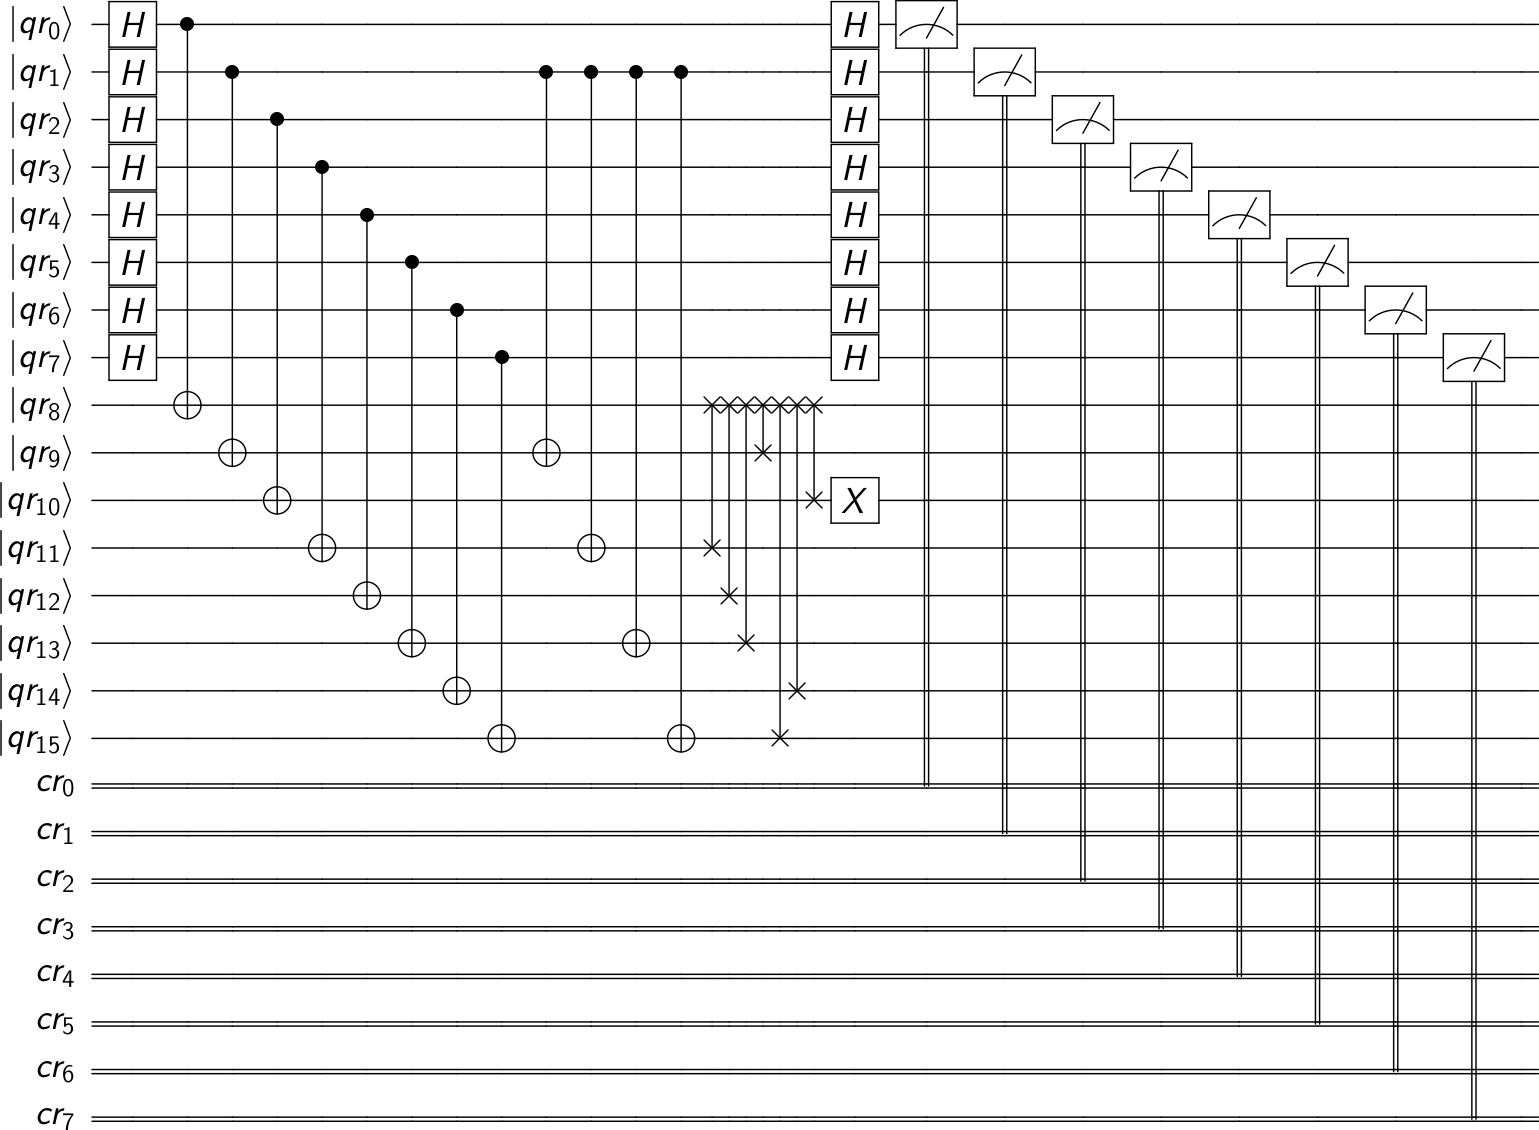

In [17]:
# Step 4 apply Hadamard gates to the first register
for i in range(n):
    simonCircuit.h(qr[i])
    
# Step 5 perform measurement on the first register
for i in range(n):
    simonCircuit.measure(qr[i], cr[i])

#draw the circuit
from qiskit.tools.visualization import circuit_drawer
circuit_drawer(simonCircuit)

## Experimenting with Simulators

We show the experiments of finding the hidden integer with simulators.

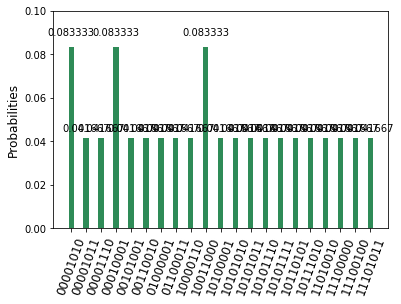

In [18]:
# use local simulator
backend = "local_qiskit_simulator"
# the number of shots is twice the length of the bitstring
shots = 3*n
results = Q_program.execute([circuitName], backend=backend, shots=shots)
answer = results.get_counts(circuitName)

plot_histogram(answer)

We can see that the results of the measurements are the basis whose inner product with the hidden string $s$ are zero. 

*(Notice that the basis on the label of the x-axis in the above plot are numbered from right to left instead of from left to right that we used for $s$* 

In [19]:
# Constructing the system of linear equations Y s = 0
# By k[::-1], we reverse the order of the bitstring
lAnswer = [ (k[::-1],v) for k,v in answer.items() if k != "0"*n  ] #excluding the trivial all-zero
#Sort the basis by their probabilities
lAnswer.sort(key = lambda x: x[1], reverse=True)

Y = []
for k, v in lAnswer:
    Y.append( [ int(c) for c in k ] )


#import tools from sympy
from sympy import Matrix, pprint, MatrixSymbol, expand, mod_inverse


Y = Matrix(Y)

#pprint(Y)

#Perform Gaussian elimination on Y
Y_transformed = Y.rref(iszerofunc=lambda x: x % 2==0) # linear algebra on GF(2) 

#to convert rational and negatives in rref of linear algebra on GF(2)
def mod(x,modulus):
    numer, denom = x.as_numer_denom()
    return numer*mod_inverse(denom,modulus) % modulus

Y_new = Y_transformed[0].applyfunc(lambda x: mod(x,2)) #must takecare of negatives and fractional values
#pprint(Y_new)

print("The hidden bistring s[ 0 ], s[ 1 ]....s[",n-1,"] is the one satisfying the following system of linear equations:")
rows, cols = Y_new.shape
for r in range(rows):
    Yr = [ "s[ "+str(i)+" ]" for i, v in enumerate(list(Y_new[r,:])) if v == 1 ]
    if len(Yr) > 0:
        tStr = " + ".join(Yr)
        print(tStr, "= 0")


The hidden bistring s[ 0 ], s[ 1 ]....s[ 7 ] is the one satisfying the following system of linear equations:
s[ 0 ] = 0
s[ 1 ] + s[ 7 ] = 0
s[ 2 ] = 0
s[ 3 ] + s[ 7 ] = 0
s[ 4 ] = 0
s[ 5 ] + s[ 7 ] = 0
s[ 6 ] = 0


As seen above, the system of linear equations is satisfied by the hidden integer $s$. Notice that there can be more than one solutions to the system. In fact, all-zero bitstring is a trivial solution to the system of linear equations. But by having more samples one can narrow down the candidates of the solution, and then test the solution by querying the blackbock in the classical manner.

## Experimenting with Real Devices

We see how one can still find out the hidden integer by running the Simon algorithm on real devices. Due to imperfect quantum computers, obtaining the conclusion is not as easy as done with the simulator of perfect quantum computers.

In [ ]:
backend = "ibmqx5"

# show the status of the backend
print(get_backend_instance(backend).status)

shots = 4*n #run more experiments to be certain

if get_backend_instance(backend).status["available"] is True:
    results = Q_program.execute([circuitName], backend=backend, shots=shots, timeout=600)
    answer = results.get_counts(circuitName)

    plot_histogram(answer)
    
    # Constructing the system of linear equations Y s = 0
    # By k[::-1], we reverse the order of the bitstring
    lAnswer = [ (k[::-1],v) for k,v in answer.items() if k != "0"*n  ] #excluding the trivial all-zero
    #Sort the basis by their probabilities
    lAnswer.sort(key = lambda x: x[1], reverse=True)

    Y = []
    for k, v in lAnswer:
        Y.append( [ int(c) for c in k ] )

    Y = Matrix(Y)

    #Perform Gaussian elimination on Y
    Y_transformed = Y.rref(iszerofunc=lambda x: x % 2==0) # linear algebra on GF(2) 

    print("The hidden bistring s[ 0 ], s[ 1 ]....s[",n-1,"] is the one satisfying the following system of linear equations:")
    rows, cols = Y_transformed[0].shape
    for r in range(rows):
        Yr = [ "s[ "+str(i)+" ]" for i, v in enumerate(list(Y_transformed[0][r,:])) if v == 1 ]
        if len(Yr) > 0:
            tStr = " + ".join(Yr)
            print(tStr, "= 0")


We indeed see that the outcome is the binary representation of the hidden integer $s$ with high probability. 

## References

[1] "[On the power of quantum computation](https://epubs.siam.org/doi/abs/10.1137/S0097539796298637)", Daniel R. Simon, SIAM J. Comput., 26(5), 1474–1483 (1997) 